In [1]:
%load_ext autoreload

In [2]:
%autoreload

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from ltl.policies import CategoricalPolicy
from ltl.algorithms import REINFORCE
import numpy as np
import matplotlib
from matplotlib import animation
from IPython.display import HTML

In [3]:
env = gym.make_vec('CartPole-v1', num_envs=16, vectorization_mode="async", max_episode_steps=500, render_mode='rgb_array')
obs, info = env.reset(seed=0)

In [4]:
policy = CategoricalPolicy(4, 2, 32)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

agent = REINFORCE(gamma=0.99)

In [5]:
frames = {
    0: [],
    100: [],
    200: [],
}

losses = []
rewards = []
episodes = 250

for i in (pbar := tqdm(range(episodes))):

    optimizer.zero_grad()
    
    obs, info = env.reset(seed=0)
    
    if i in frames.keys():
        frames[i].append(env.render())
        
    agent.reset()
    done = np.array([False])
    while not done.all():
        conditioner = policy(obs)
        action, action_log_prob = policy.sample(conditioner)
        obs, reward, terminated, truncated, info = env.step(action)
        reward = reward * (1 - done.astype(float)) # 0 for envs that are done
        agent.update(reward, action, action_log_prob)
        done = done | (terminated | truncated)

        if i in frames.keys():
            frames[i].append(env.render())
        
    loss, total_reward = agent.get_loss()

    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    rewards.append(total_reward.mean().item())
    pbar.set_description(f"reward: {total_reward.mean():.4f}")

frames = {k: np.stack(v) for k, v in frames.items()}

  0%|          | 0/250 [00:00<?, ?it/s]

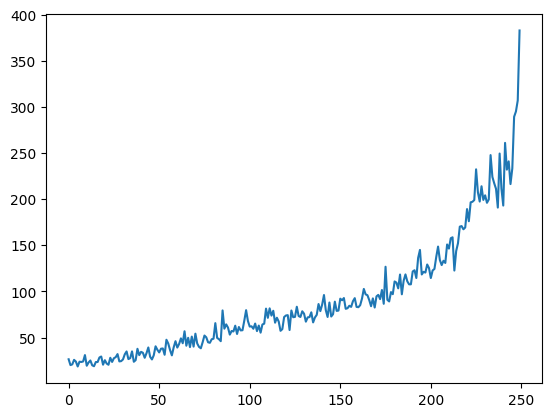

In [6]:
plt.plot(rewards)

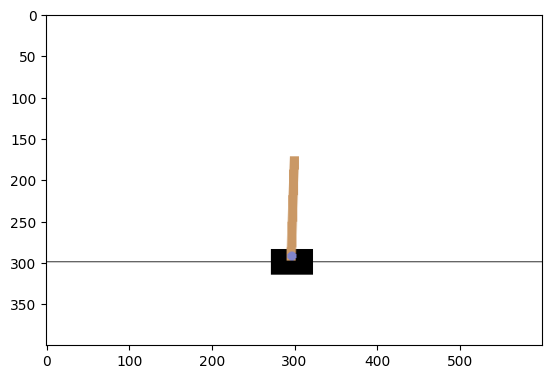

In [11]:
ep_num = 200
env_num = 2

fig, ax = plt.subplots()
im = ax.imshow(frames[ep_num][0, env_num], cmap='viridis', animated=True)

def update(i):
    im.set_array(frames[ep_num][i, env_num])
    return im,

anim = animation.FuncAnimation(fig, update, frames=frames[ep_num].shape[0], interval=50, blit=True);

In [12]:
HTML(anim.to_html5_video())